<a href="https://colab.research.google.com/github/Mayank-Chandra17/Multi-Factor-Regression-Model-/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import pandas as pd
index_series=pd.read_csv("index1.csv",parse_dates=["Date"],index_col="Date")["Price"]
factors_df=pd.read_csv("factors1.csv",parse_dates=["Date"],index_col="Date")

In [96]:
factors_monthly=factors_df.resample("M").mean()
index_monthly=index_series.resample("M").last()

/tmp/ipython-input-3008905357.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  factors_monthly=factors_df.resample("M").mean()
/tmp/ipython-input-3008905357.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_monthly=index_series.resample("M").last()


In [97]:
y=index_monthly.pct_change().dropna()
X=factors_monthly.pct_change().dropna()

In [98]:
common_idx = y.index.intersection(X.index)
y=y.loc[common_idx]
X=X.loc[common_idx]

In [99]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [100]:
import statsmodels.api as sm
X_train_const=sm.add_constant(X_train)
X_test_const=sm.add_constant(X_test)

In [101]:
model=sm.OLS(y_train,X_train_const).fit()

In [102]:
y_train_pred=model.predict(X_train_const)
y_test_pred=model.predict(X_test_const)

In [103]:
from sklearn.metrics import r2_score
r2_train=r2_score(y_train,y_train_pred)
r2_test=r2_score(y_test,y_test_pred)
print("R²Train=",r2_train)
print("R²Test=",r2_test)

R²Train= 0.011334611201025968
R²Test= -0.03300697745996661


In [104]:
X_const=sm.add_constant(X)
contrib=X_const.mul(model.params,axis=1)
contrib["Predicted_Return"]=contrib.sum(axis=1)

In [112]:
import json
recent=contrib.iloc[-1]
output={"r_squared_train":float(r2_train),"r_squared_test":float(r2_test),
    "coefficients":model.params.to_dict(),
    "recent": {"date":common_idx[-1].strftime("%Y-%m-%d"),
        "predicted_return":float(recent["Predicted_Return"]),
        "factor_contributions":recent.drop("Predicted_Return").to_dict()}}
with open("factor_attribution.json","w") as f:
    json.dump(output,f,indent=2)
print("Most recent contributions:")
print(output["recent"]["factor_contributions"])

Most recent contributions:
{'const': 0.00042289759139075385, 'Oil': -0.0003973312935975058, 'EURUSD': -0.002158110245401682, 'VIX': -0.0012776490165514165, 'XLK': 0.001775230769942389}


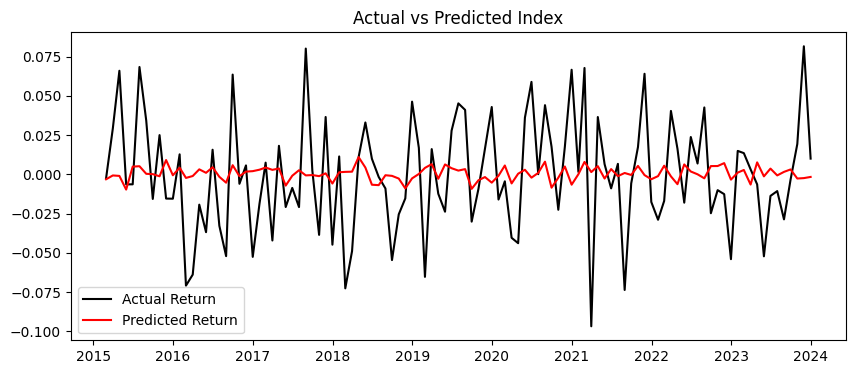

In [113]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(y.index,y,label="Actual Return",color="black")
plt.plot(y.index,contrib["Predicted_Return"],label="Predicted Return",color="red")
plt.legend()
plt.title("Actual vs Predicted Index")
plt.show()

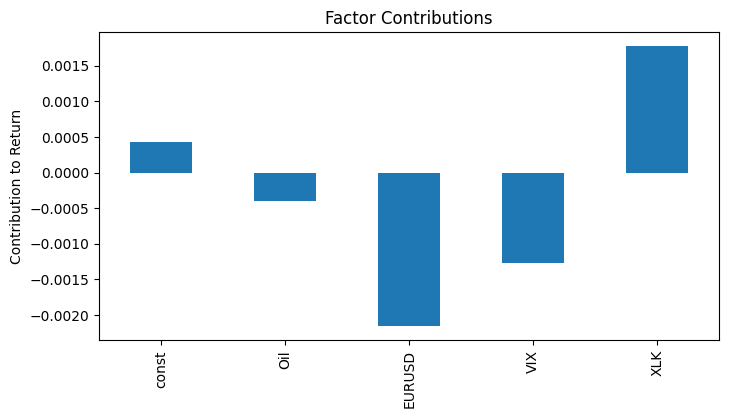

In [114]:
plt.figure(figsize=(8,4))
recent.drop("Predicted_Return").plot(kind="bar")
plt.title(f"Factor Contributions")
plt.ylabel("Contribution to Return")
plt.show()
